In [15]:
# Importy
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [16]:
# Wczytanie danych
X_train = np.loadtxt("samsung_train.txt")
X_test  = np.loadtxt("samsung_test.txt")

y_train = np.loadtxt("samsung_train_labels.txt")
y_test  = np.loadtxt("samsung_test_labels.txt")

X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

In [17]:
# Skalowanie
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

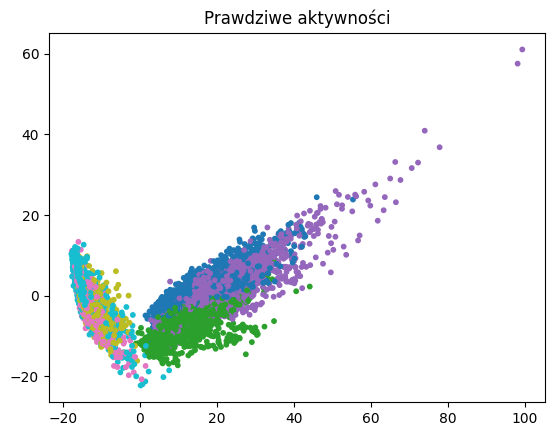

In [18]:
# PCA – redukcja wymiarów
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="tab10", s=10)
plt.title("Prawdziwe aktywności")
plt.show()

KMeans

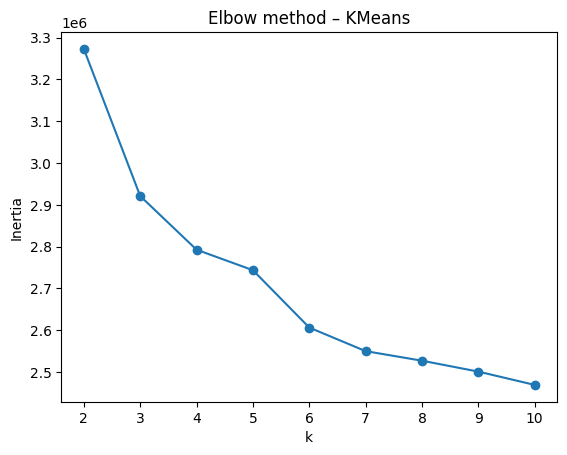

In [19]:
# Dobór liczby klastrów
inertias = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(range(2,11), inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow method – KMeans")
plt.show()

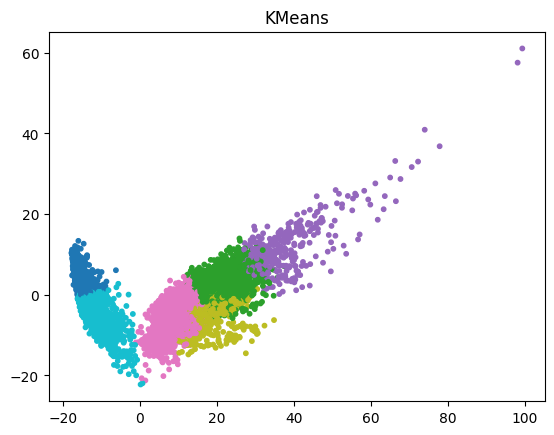

ARI: 0.2850641901721631
Silhouette: 0.11706978147952803


In [20]:
# Klasteryzacja
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_clusters = kmeans.fit_predict(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans_clusters, cmap="tab10", s=10)
plt.title("KMeans")
plt.show()

print("ARI:", adjusted_rand_score(y, kmeans_clusters))
print("Silhouette:", silhouette_score(X_scaled, kmeans_clusters))

Gaussian Mixture Models

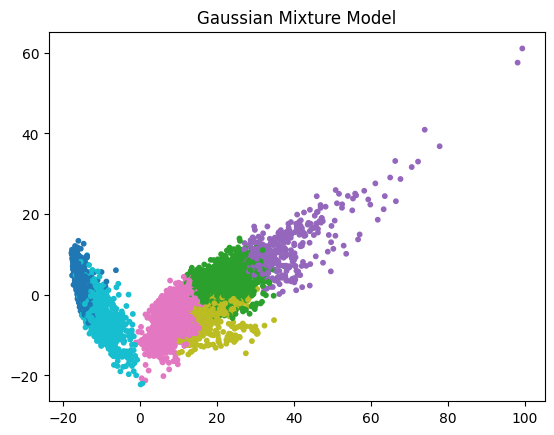

ARI: 0.2874395263878364
Silhouette: 0.13453629259906688


In [21]:
gmm = GaussianMixture(n_components=6, covariance_type="full", random_state=42)
gmm_clusters = gmm.fit_predict(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], c=gmm_clusters, cmap="tab10", s=10)
plt.title("Gaussian Mixture Model")
plt.show()

print("ARI:", adjusted_rand_score(y, gmm_clusters))
print("Silhouette:", silhouette_score(X_scaled, gmm_clusters))

DBSCAN

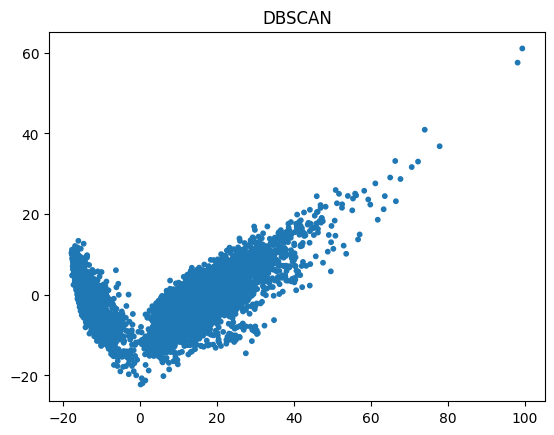

Liczba klastrów: 0


In [22]:
dbscan = DBSCAN(eps=2.5, min_samples=5)
db_clusters = dbscan.fit_predict(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], c=db_clusters, cmap="tab10", s=10)
plt.title("DBSCAN")
plt.show()

print("Liczba klastrów:", len(set(db_clusters)) - (1 if -1 in db_clusters else 0))

Wnioski:


---


Algorytmy KMeans i Gaussian Mixture Models uzyskały umiarkowaną zgodność z rzeczywistymi etykietami aktywności (ARI ≈ 0.28). Najlepiej rozpoznawalne były aktywności statyczne (leżenie, siedzenie, stanie), natomiast aktywności dynamiczne (marsz, wchodzenie i schodzenie po schodach) często były mylone.

Algorytm DBSCAN nie wykrył żadnych klastrów, co wynika z wysokiej wymiarowości danych oraz braku wyraźnych obszarów o dużej gęstości.

Klastering jako preprocessing → supervised learning

In [23]:
X_supervised = np.column_stack([X_scaled, kmeans_clusters])

X_train_sup = X_supervised[:len(X_train)]
X_test_sup  = X_supervised[len(X_train):]

Random Forest

In [24]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 20]
}

grid_rf = GridSearchCV(rf, param_grid, cv=3)
grid_rf.fit(X_train_sup, y_train)

print(grid_rf.best_score_)


0.9102297271417746


SVM

In [25]:
svm = SVC()

param_grid = {
    "C": [1, 10],
    "gamma": ["scale", "auto"]
}

grid_svm = GridSearchCV(svm, param_grid, cv=3)
grid_svm.fit(X_train_sup, y_train)

print(grid_svm.best_score_)


0.9317209413345102


Podsumowanie

---


Prównano algorytmy klasteringu KMeans, Gaussian Mixture Models oraz DBSCAN na zbiorze danych Samsung HAR. Dane zostały wystandaryzowane, a zbiory treningowy i testowy połączono, ponieważ klastering nie wykorzystuje etykiet klas.

KMeans i GMM uzyskały umiarkowaną zgodność z rzeczywistymi aktywnościami (ARI ≈ 0.28). Najlepiej rozpoznawane były aktywności statyczne (leżenie, siedzenie, stanie), natomiast aktywności dynamiczne (marsz, wchodzenie i schodzenie po schodach) często były mylone. GMM osiągnął nieznacznie lepsze wyniki dzięki możliwości modelowania klastrów o eliptycznym kształcie.

Algorytm DBSCAN nie wykrył żadnych klastrów, co wynika z bardzo wysokiej wymiarowości danych i braku wyraźnych obszarów o dużej gęstości. Wyniki pokazują ograniczenia metod klasteringu w odwzorowywaniu rzeczywistych typów aktywności fizycznej.

Odpowiedzi


---
Czy potrzeba wszystkich cech?

Nie. Zbiór wiele cech, z których wiele jest silnie skorelowanych. W klasteringu wysoka wymiarowość utrudnia separację danych, dlatego wskazane jest skalowanie oraz ewentualna redukcja wymiarów (np. PCA), szczególnie do wizualizacji.

Czy potrzebna jest jakaś obróbka?

Tak. Dane muszą zostać wystandaryzowane, ponieważ algorytmy klasteringu są wrażliwe na skalę cech. Bez skalowania wyniki klasteryzacji byłyby niepoprawne.

Czy wiemy, jak obrobić?

Tak. Zastosowano standardowe metody preprocessingu: standaryzację danych oraz redukcję wymiarów metodą PCA.

Czy wiemy, co znaczy każda cecha?

Nie jest to konieczne. Cechy reprezentują statystyki sygnałów z czujników (akcelerometr, żyroskop). W klasteringu istotna jest struktura danych, a nie interpretacja pojedynczych cech.

Czy potrzebujemy aż dwóch plików (train i test)?

Nie na etapie klasteringu. Algorytmy unsupervised learning nie korzystają z etykiet, dlatego zbiory treningowy i testowy zostały połączone. Podział ten ma znaczenie dopiero w części supervised learning.

Czy w Unsupervised Learning potrzebny jest podział na dane treningowe i testowe?

Nie. W klasteringu nie występuje proces uczenia na etykietach, dlatego podział train/test nie jest wymagany. Etykiety zostały użyte wyłącznie do oceny jakości klastrów.

Czym różni się KMeans, K-Fold i K Nearest Neighbors?

KMeans – algorytm klasteringu typu unsupervised, który dzieli dane na K klastrów poprzez minimalizację odległości do centroidów.

K-Fold – technika walidacji krzyżowej, służąca do oceny modeli uczenia nadzorowanego, nie jest algorytmem uczenia maszynowego.

K Nearest Neighbors (KNN) – algorytm klasyfikacji typu supervised, który przypisuje klasę na podstawie K najbliższych sąsiadów w przestrzeni cech.
